In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preproccesed-oth-dataset/weed/weed_267.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_329.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_554.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_525.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_430.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_39.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_357.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_580.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_123.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_479.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_348.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_36.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_643.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_177.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_14.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_879.png
/kaggle/input/preproccesed-oth-dataset/weed/weed_175.png
/kaggle/input/preproccesed-oth-dat

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import numpy as np

In [33]:
# Part 2: Define Dataset Path and Hyperparameters
data_path = '/kaggle/input/preproccesed-oth-dataset'

batch_size = 8
num_epochs = 25
learning_rate = 0.0001
patience = 2


In [20]:
# Part 3: Data Augmentation and Dataset Preparation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

dataset = datasets.ImageFolder(data_path, transform=data_transforms['train'])
class_names = dataset.classes

data_len = len(dataset)
train_len = int(0.7 * data_len)
val_len = int(0.15 * data_len)
test_len = data_len - train_len - val_len

train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])
val_set.dataset.transform = data_transforms['val']
test_set.dataset.transform = data_transforms['test']

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [21]:
# Part 4: Load Pretrained Model and Setup
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
def train_model():
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        correct_train = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data).item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = correct_train / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels.data).item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_val / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=True)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return history


# Part 6: Train the Model
history = train_model()


Epoch 1/25


100%|██████████| 123/123 [00:13<00:00,  9.28it/s]


Train Loss: 0.0087, Train Acc: 0.9969, Validation Loss: 0.0270, Validation Acc: 0.9929
Epoch 2/25


100%|██████████| 123/123 [00:13<00:00,  9.36it/s]


Train Loss: 0.0158, Train Acc: 0.9964, Validation Loss: 0.0567, Validation Acc: 0.9929
Epoch 3/25


100%|██████████| 123/123 [00:12<00:00,  9.51it/s]


Train Loss: 0.0085, Train Acc: 0.9980, Validation Loss: 0.0193, Validation Acc: 0.9929
Epoch 4/25


100%|██████████| 123/123 [00:12<00:00,  9.61it/s]


Train Loss: 0.0045, Train Acc: 0.9990, Validation Loss: 0.0146, Validation Acc: 0.9976
Epoch 5/25


100%|██████████| 123/123 [00:12<00:00,  9.60it/s]


Train Loss: 0.0110, Train Acc: 0.9969, Validation Loss: 0.0320, Validation Acc: 0.9929
Epoch 6/25


100%|██████████| 123/123 [00:12<00:00,  9.54it/s]


Train Loss: 0.0058, Train Acc: 0.9980, Validation Loss: 0.0297, Validation Acc: 0.9905
Early stopping triggered


In [35]:
# Part 7: Load Best Model
model.load_state_dict(torch.load('best_model.pth', weights_only=True))


<All keys matched successfully>

In [31]:
# Part 8: Evaluate the Model
def evaluate_model():
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

labels, preds = evaluate_model()

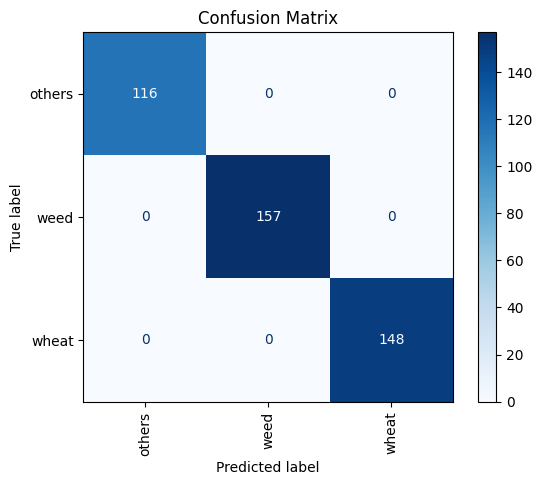

In [25]:
# Part 9: Generate Metrics
conf_mat = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')  # Added xticks rotation for better readability
plt.title("Confusion Matrix")
plt.show()


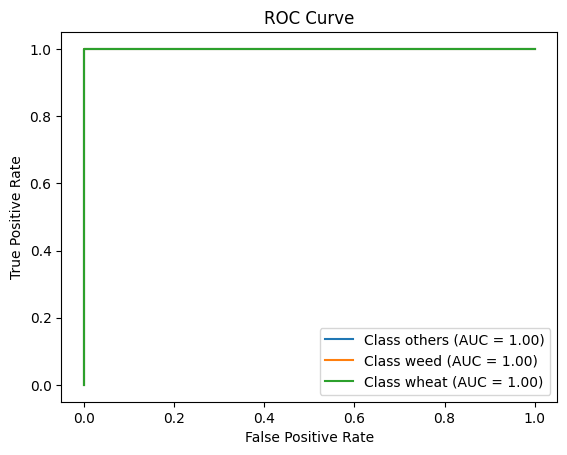

In [26]:
# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_names)):
    y_true = (labels == i).astype(int)
    y_score = (preds == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.show()


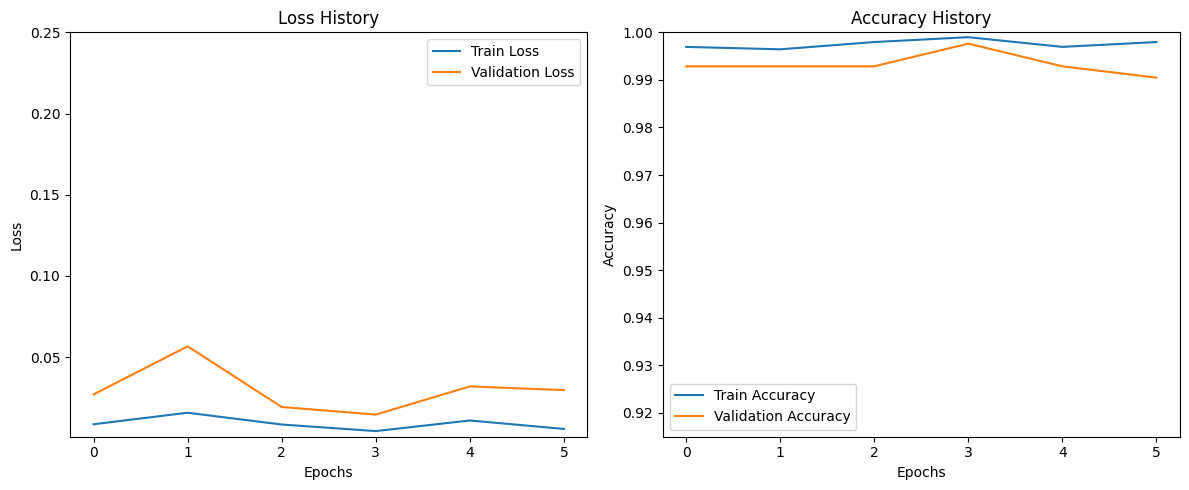

In [41]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.001, 0.25)
plt.legend()
plt.title('Loss History')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.915, 1.0)
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

In [43]:
torch.save(model,'best_model.pth')